## Project 3 - Subreddit API and NLP

### **Problem Statement**

Taco Bell holds the largest share of the Mexican-style restaurant market in the US. A main driver of Taco Bell’s success is their product innovation (think Doritos Tacos Locos). Taco Bell has successfully incorporated popular elements of Mexican cuisine to craft an exciting menu that attracts over 40 million customers on a weekly basis. 

**_The product innovation team has task the data science team to search for other popular elements of Mexican cuisine that are currently missing from their menu._**

### **Approach**

In order to tackle this problem, I will analyze posts from the r/tacobell and the r/mexicanfood subreddits to extract items that are popular in mexican cuisine but missing in the Taco Bell menu. 

Benefits of using subreddit posts:
- Content rich (posts are allowed over 40,000 characters)
- Observe directly how consumers from each group write about food items they like
- The r/mexicanfood subreddit highlights popular and favorite foods

**EDA**
- Explore sentiment analysis with VADER
    -  What differences are there in sentiment between each subreddit
- Explore commong words after vectorizing
    -  What are common words in each subreddit
    
**Modeling**

Although our problem statement is not concerned with predictions, I will explore different classification models to learn more about the differences between each subreddit. These models use the vocabulary from each posts to predict from which subreddit the post originated. Therefore, looking at the words the models has identified as most important to differentiate both groups can help us identify food-related words from the r/mexicanfood subreddit that are not in the r/tacobell subreddit and highlight opportunities for Taco Bell to expand its menu. 


### **The Data**

The data used for this analysis was extracted from the r/tacobell and the r/mexicanfood subreddits using Reddit's API. To see code for extracting and filtering the data, please refer to the get_data.ipynb notebook in this repository. 

#### Data Dictionary

|Feature|Type|Datase|Description|
|---|---|---|---|
|author|object|subreddits|Reddit username of the author|
|selftext|object|subreddits|Text in the post|
|title|object|subreddits|Title of the post|
|subreddit|object|subreddits|The subreddit where the post originates (target variable)|
|selftext_lenth|int|subreddits|The length of the post|
|selftext_words|int|subreddits|Count of the total words in the post|
|sentiment_score|float|subreddits|Compound sentiment score from VADER|
|sentiment|object|subreddits|Sentiment classification based on the compound sentiment score|

In [300]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
precision_score, f1_score, classification_report, RocCurveDisplay, 
balanced_accuracy_score)

In [2]:
# import nltk
# nltk.download('vader_lexicon')

### Importing the csv files I created from the reddit API 

In [3]:
taco_bell = pd.read_csv('./Data/tacobell.csv')

In [4]:
mex_food = pd.read_csv('./Data/mex_food.csv')

In [5]:
tacobell = taco_bell.loc[:,['author', 'selftext', 'title', 'subreddit']]

In [6]:
tacobell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     1187 non-null   object
 1   selftext   1187 non-null   object
 2   title      1187 non-null   object
 3   subreddit  1187 non-null   object
dtypes: object(4)
memory usage: 37.2+ KB


In [7]:
mexican_food = mex_food.loc[:,['author', 'selftext', 'title', 'subreddit']]

In [8]:
mexican_food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     1185 non-null   object
 1   selftext   1185 non-null   object
 2   title      1185 non-null   object
 3   subreddit  1185 non-null   object
dtypes: object(4)
memory usage: 37.2+ KB


### Concatenate the dataframes

In [9]:
subreddits = pd.concat([tacobell, mexican_food], ignore_index=True)

In [10]:
#subreddits.to_csv('./Data/subreddits.csv', index=False)

In [11]:
subreddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     2372 non-null   object
 1   selftext   2372 non-null   object
 2   title      2372 non-null   object
 3   subreddit  2372 non-null   object
dtypes: object(4)
memory usage: 74.2+ KB


In [12]:
subreddits.head()

,author,selftext,title,subreddit
0,mooshakez,Under $2. Delicious. Holy crap these are good,First time trying nacho fries.,tacobell
1,kevinmattress,Give us the option to pay an upcharge to swap ...,How to Improve the My Cravings Box,tacobell
2,improvius,"Every time I try to log in using Facebook, I g...",Can't log in to tacobell.com with facebook,tacobell
3,lostsurfer24t,i liked the supreme and maybe a baja one\n\n&a...,i miss the original gorditas that came in 3 op...,tacobell
4,bannanmonk,"Not sure if everyone knew this but me, but jus...",Tacobell pizza will return as a permanent item.,tacobell


#### Clean some a few weird characters

In [13]:
subreddits['selftext'] = subreddits['selftext'].apply(lambda x: x.replace('\n', ''))

subreddits['selftext'] = subreddits['selftext'].apply(lambda x: x.replace('&amp;#x200B;', ''))

In [14]:
subreddits.isnull().sum()

author       0
selftext     0
title        0
subreddit    0
dtype: int64

### EDA 

#### How many unique authors do we have on each subreddit?

In [15]:
tacobell['author'].nunique()

1022

In [16]:
mexican_food['author'].nunique()

999

**Unique contributors**

- For the tacobell dataframe, out of 1187 posts, we have 1022 unique contributors.

- For the mexican food dataframe, out of 1185, we have 999 unique contributors. 


#### Create new columns to measure length of post and words in posts

In [17]:
subreddits['selftext_length'] = subreddits['selftext'].str.len()

In [18]:
subreddits['selftext_words'] = subreddits['selftext'].str.split(' ').str.len()

#### Distribution of posts lengths

In [21]:
tacobell = subreddits.loc[subreddits['subreddit']=='tacobell']

mex_food = subreddits.loc[subreddits['subreddit']=='mexicanfood']

In [65]:
sns.set_style('darkgrid')
sns.set_context('talk')

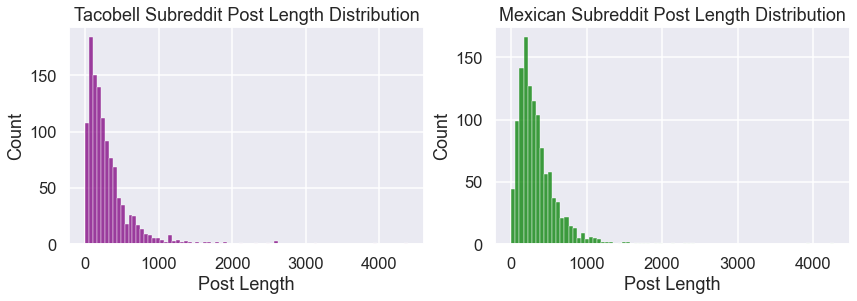

In [66]:
fig, ax = plt.subplots(1, 2,figsize=(14, 4))

sns.histplot(ax=ax[0], data=tacobell, x='selftext_length', color='purple')

sns.histplot(ax=ax[1], data=mex_food, x='selftext_length', color='green')

ax[0].title.set_text('Tacobell Subreddit Post Length Distribution')
ax[1].title.set_text('Mexican Subreddit Post Length Distribution')
ax[0].set_xlabel('Post Length')
ax[1].set_xlabel('Post Length');
plt.savefig('compare post lenght dist', bbox_inches='tight')

Both subreddits have a similar distribution of post length. However, for the tacobell subreddit, the shorter posts tend to be longer than for the mexican food subreddit

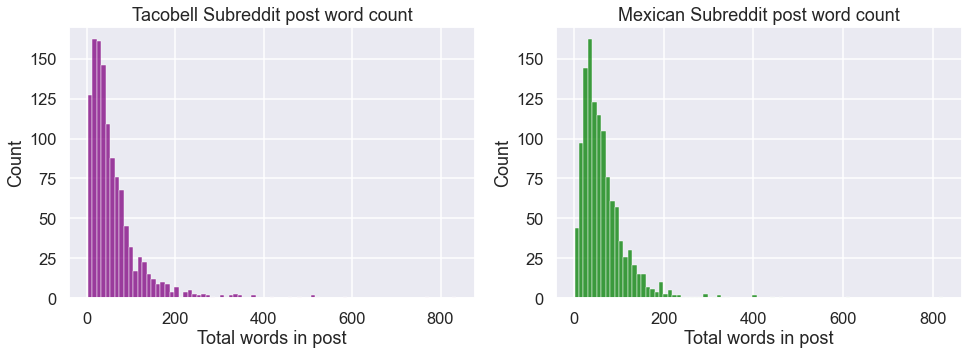

In [24]:
fig, ax = plt.subplots(1, 2,figsize=(16, 5))

sns.histplot(ax=ax[0], data=tacobell, x='selftext_words', color='purple')

sns.histplot(ax=ax[1], data=mex_food, x='selftext_words', color='green')

ax[0].title.set_text('Tacobell Subreddit post word count')
ax[1].title.set_text('Mexican Subreddit post word count')
ax[0].set_xlabel('Total words in post')
ax[1].set_xlabel('Total words in post');
plt.savefig('total words dist', bbox_inches='tight')

### Exploring sentiment scores in both subreddits

We will be using VADER (Valence Aware Dictionary and sEntiment Reasoner), which is a lexicon and rule-based sentiment analysis tool that is attunned to sentiments expressed in social media. 

VADER returns 4 scores per post: positive, neutral, negative, and compound. For the purpose of our analysis, I will only use the compound score which is the sum of positive, neutral, and negative scores which is then normalized between 1 and -1, with 1 being most positive and -1 being most negative. 

In [25]:
sia = SentimentIntensityAnalyzer()

In [26]:
subreddits['sentiment_score'] = subreddits['selftext'].apply(lambda x:sia.polarity_scores(x)['compound'])

In [27]:
conditions = [
        (subreddits['sentiment_score'] >= 0.05), 
        (subreddits['sentiment_score'] < 0.05) & (subreddits['sentiment_score'] > -0.05),
        (subreddits['sentiment_score'] <= -0.05)
]

values = ['positive', 'neutral', 'negative']

subreddits['sentiment'] = np.select(conditions, values)

#### Create seperate dfs so we can compare sentiment between both groups

In [28]:
tacobell = subreddits.loc[subreddits['subreddit']=='tacobell']

mex_food = subreddits.loc[subreddits['subreddit']=='mexicanfood']

#### Focusing on very positive posts in both groups. 

In [29]:
tb_very_positive = tacobell.query('sentiment_score > .70')

In [30]:
mf_very_positive = mex_food.query('sentiment_score > .70')

In [232]:
tb_very_positive.sample(n=5, random_state=29)[['selftext', 'title', 'sentiment_score']]

,selftext,title,sentiment_score
957,"First they get rid of the loaded grillers, even though they have all the ingredients and equipment to make them. Now they got rid of the beef burrito, the best value in fast food. Now I don't hate taco bell, but their prices are literally no different than actual authentic Mexican restaurant we have in town. There is zero reason to go here, it's great but we all know we're eating garbage. At least I can go pick up my tacos at a restaurant where none of the employees speak a lick of English, now that's authentic and pretty damn good food too.",Went to taco bell for lunch at work today and unfortunately it will be the last time ever.,0.9293
658,"I have dined on Taco Bell most of my life. Almost too much in high school, to the point it’s not so much now. But every now and then, the craving sets in.Unbeknownst to me, you can customize the everting shit out of their food. I just discovered this the other night. I got a bean burrito, add rice, add jalapeños. It was less appetizing than expected. Only because I am to believe they skimped on the red sauce and onions…. I also received no napkins or sauce packets, but I digress…..I joined this forum as part of my new quest: to discover the customization options that lead to the perfect Taco Bell bean burrito.Please. Sisters. Brothers. Shared lovers of deliciously sub-par Mexican food. Lend me your recipes. What do YOU add to your bean burrito? I must know.",The perfect bean burrito,0.8720
892,"Provided the following modifications are made: add jalapeños, remove guac, and grill it.This food combination is the single best item I have ever had at TB. It is so huge and filling for $2. A very good value and a great combination of textures and flavors. So far I have had like 8 of these, and every time they have absolutely nailed my modifications at multiple locations.I was disappointed in the Grilled Cheese Burrito mainly because they never got my order right, not once, but this new offering has completely redeemed themselves for me. This one better stay around, and honestly for as big as they have been making them I would even pay $3 for them.",The Fiesta Veggie Burrito is the best thing I have ever had at TB.,0.9608
9,"So I used to work at a Taco Bell on my campus for three years. I usually closed since that was when you'd be able to take a good haul home (unofficially of course). The Cheesy Gordita Crunch and the Crunchwrap are my two favorite items at TB. One night I decided to combine the two together and it became my go-to item. Basically, after you add the meat and cheese of the crunchwrap, instead of just adding a tostada you add a flatbread with three cheese (steam it first). Then you add the tostada, an extra scoop of beef, and the rest is like making a regular crunchwrap. It honestly tastes so good and I wish I could get it at a regular taco bell, I just don't think the price is worth it (also explaining it every time). I'm just curious if anyone else has tried that or what other combinations people have made.",Anyone else try a Cheesy Gordita Crunch-wrap?,0.9641
208,"Is anyone in the Phoenix area noticing that there is no Baja Blast available? Granted I’ve only experienced this at two restaurants, but it’s continued for over a week. WE NEED ANSWERS. Please let me know if there’s anything going on that I can be made aware of, and most importantly, what I can do to help.",PHOENIX AREA BAJA BLAST SHORTAGE,0.8686


We can see that VADER has its limitations, it does not do a good job of understanding context, but it does pick up on positive words. For the tacobell subreddit, in the sample above, the posts are about menu item recommendations. A huge miss on the part of VADER was accurately detecting that the post about the price increase is overwhelmingly negative. The post about the Bala Blast shortage is also more negative than positive in my opinion. 

Though the sample above is quite small, I have gone through many of these positive posts by hand. I have noticed that people really enjoy the Taco Bell food items for what they are: convenient, cheap, and delicious. Many happy folks emphasize items that are a good value.   

In [234]:
mf_very_positive.sample(n=5, random_state=529)[['selftext', 'title', 'sentiment_score']]

,selftext,title,sentiment_score
1729,"Hey r/mexicanfood! Wondering if y'all can help me. I knowwwwww that Mexican food is/can be healthy. BUT... my relationship to Mexican food has always been comfort food. Basically, whatever my Granny would cook. It's so tasty, but maybe not calorically friendly. I'm on a journey to get to a healthy weight and lifestyle, but I want to introduce and experience flavors and meals reminiscent of what I grew up eating. So, do y'all have any recipes, meals, ingredient replacements, or food bloggers you can recommend to me?",I'm tired of eating dumb salads,0.8201
1611,"Hi everyone, As the titel already suggests, I'm looking for some great vegetarian mexican recipes. Both my BF and I love mexican food, and for his birthday we want to try making our own tortillas and I want to make something special to go with these tortillas (a filling, sauce, etc..). However, since he is a vegetarian we cannot go the obvious route of the more expensive meats/fish such as steak or lobster.It would be great if you could share some of your favorite veggie recipes or help me with some inspiration! Thanks very much in advance!",Looking for great vegetarian mexican recipes,0.9841
1936,Hello! I purchased a bottle of Crema Mexicana back in February of this year.. I didn’t open it until today. All it says on the bottle is sell by Mar 31 2020. Is it still consumable?? Thanks in advance! :),How long is crema Mexicana good for unopened?,0.7810
1329,"My old college town had a Mexican place where, at the condiments bar, there was a sauce I would go crazy for and I'm trying to figure out what it was so I can get it myself.To describe it, it was just about pure white, but it was very runny and liquidy. It did have small chunks of what I assumed to be green chile and tomato. It didn't really taste too cheesy, but I guess I wouldn't be surprised if it did have some cheese in it. Other than that it was a definitely salty/savory and creamy. Thanks in advance!","Need help identifying a sauce, not sure if this is just a special crema/sour cream or just a different kind of queso blanco?",0.7178
1382,"Cold season has arrived! I'm getting the cravings to make chocolate caliente. However, after finding out Chocolate Abuelita is owned by Nestle, I am interested in finding out other brands or a home recipe. Anyone know any other brands like Abuelita or a good home recipe?",Chocolate Abuelita alternatives?,0.8122


Again, for these posts, we see VADER's limitations in understanding context. I would have expected posts with such high scores to be raving specific mexican food items, instead, many are asking the subreddit for recommendations.

That being said, I have explored many of these posts and have noticed that people mention and ask a lot about salsas (sauces). Posters also pay much attention to meat (carne) preparations. 

#### Focusing on very negative posts in both groups. 

In [33]:
tb_very_neg = tacobell.query('sentiment_score < -.70')
mf_very_neg = mex_food.query('sentiment_score < -.70')

In [235]:
tb_very_neg.sample(n=5, random_state=529)[['selftext', 'title', 'sentiment_score']]

,selftext,title,sentiment_score
832,"I've been working at TB for about 4 months now. I wish I was the one making the food for all of the members here. So disappointing seeing all of these sad representations of the menu items. I always try to make sure people get what they pay for. We all know about the prices. Especially the quesadillas. I've been fucked over so many times wIth those prior to working at TB. They're almost $6 now, so I load that shit up. Coworkers seem to skimp on those the most. There's usually at least 2 people on the line though. Sometimes 3, so I can only do so much most of the time. It can be stressful,but it still feels good knowing someone is going to enjoy something you made.",I Wish Redditors Were My Customers,-0.7316
372,"I hear nothing but amazing things about the Lava Sauce, I wasn't lucky enough to have tasted it when it was available at Taco Bell.Was it spicy? Tangy?",What was the Lava Sauce like?,-0.8159
1077,"I wish you could come to my local Taco Bell, Jericho turnpike in new Hyde park. They have their shit together so if you came once and ordered some stuff and took it back to yours and be like “is this so damn hard”? There used to be a Taco Bell even closer to me but it closed and sold that space to a grocery store. That day hurt the community seeing as how Taco Bell is fast food for vegetarians and at the same time there is a heavy Indian population in this area so it was killing two birds with one stone. I was going to the one that closed since I was a teenager (35 now, fuck that’s the first time I had to write down my age since turning 35), it was literally a 5min drive and it was so insanely busy.",To all the posts about how their local Taco Bell screwed up the order,-0.9628
869,Yo whats going on? I understand shit happens and it’s not the employees fault but I just got back from visiting the TacoBell drive thru and the employee was mean af. She practically called me a bitch for ordering a chicken taco. Lol. Is there a food shortage? She mentioned ALL Taco Bell’s had that shortage issue. Anyone knows?,"Out of tomatoes, lettuce, tortillas, and chicken.",-0.8276
873,Has anyone else noticed the crunchy shells have a weird after taste? I’ve noticed it from multiple locations in two different states and I must say if I burp this nasty ass taste again I will never eat here again in my life!,Burnt tasting shells…,-0.8671


Two of the posts above are not accurately labeled, but again show's VADER's limitations. The question about Lava sause and the post about the well-functioning Taco Bell location should not have labeled negative, though the authors did use words that must have triggered VADER's negative score. This also shows the limitation of me using the compound score as opposed to looking at the negative and positive scores separately. 

I find it interesting that one post is an employee complaining about the franchise and another one is a customer complaining about a rude employee. 

After going through several of these negative posts, I have noticed many complaints are about general customer experience, locations running out of certain items, price increase. But generally, no complaints about the menu items themselves. 

In [212]:
mf_very_neg.sample(n=5, random_state=529)[['selftext', 'title', 'sentiment_score']]

,selftext,title,sentiment_score
2369,"So my girlfriend and I have been going to a local taqueria every Sunday for the last month and today I tried the torta cubana. I didn't know what to expect, but I was thinking it would be similar to a Cuban (Florida style) sandwich. I could tell it also came with an egg and some other ingredients I would have to google as my Spanish is very poor. This thing was huge, and I can only describe it as a crazy hangover sandwich. It had like a Mexican snietzchel, roast pork, ham, egg, a hotdog, lettuce, tomato, cheese, pickled jalapeño, carrots, avocado, and possibly some things I forgot or didn't notice. Does anybody have suggestions on things to try for next Sunday? Last week I had Molcajete (holy crap it's good). I've had some of the tacos, (pastor, lengua, carnitas), but I haven't been brave enough for the cabesa, or barbacoa yet.P.S. This sub is hard to find and sorry for any spelling mistakes.P.P.S. Are hotdogs commonly used in Mexico or is adding them an American thing (it was in the molcajete too)?",I had my first Torta Cubana today!,-0.8993
1612,Hey I really wanna make mole and in the recipes they all include nuts but I’m very allergic to nuts. I can eat peanuts and seeds just not tree nuts. If I just take out the nuts from a recipe will it still work ? If not do you know a recipe? Thanks,Mole recipe with no nuts ?,-0.8500
2194,"I know that most carne asada recipes call for skirt, flank or flap but I highly doubt that places like Filiberto's use those expensive cuts. Which cut of beef do you think is most common at low-cost Mexican restaurants?",Hole-in-the-wall Mex Restaurant Carne Asada?,-0.7086
1853,"(Sorry I speak/type very broken Spanish so this will be in English) I just opened a jar of SUPER old (like around a year old) fermented homemade cueritos, and my dad is telling me to put lemon on them to kill any harmful bacteria. This scares tf outta me, and the web isn't giving me any helpful results so I thought I'd ask here. Do I have to put lemon on my cueritos, and is there any bad bacteria in them?",Cueritos,-0.8223
2360,"I've got plenty of time on my hands, so I thought I'd give Rick Bayless' mole negro recipe a try. Problem? I'm in central Pennsylvania and the local options for dried chiles leaves much to be desired. The recipe calls for: 11 medium (about 5 1/2 ounces) dried mulato chiles 6 medium (about 2 ounces) dried chihualces chiles (he suggests guajillos as a substitute) 6 medium (about 2 ounces) dried pasilla chiles 1 dried chipotle chile (preferably the tan-brown chipotle meco)I did find dried chipotle and guajillo. I could not find mulato or pasilla. I couldn't even find dried anchos. Something I read suggested that New Mexico or California chiles could be used as a replacements, both of which I can find. But I'm not sure what proportions to use now. I'm not going for super authentic or anything, just something that will taste good. Suggestions on proportions I could use for the chiles I do have available to me? Or a reputable site I could order from that doesn't charge out the ass for shipping?","I want to make mole negro, but can't find the right combination of chiles",-0.8556


While the sample above is quite small, I think it is worth noting that the posts that scored high on negativity are not truly that negative. Two of the post demonstrate some concern and are asking for advice. These post are mostly asking for advice, but do not show much grievances (perhaps the one question beef cuts is a little negative. 

Compared to the tacobell subreddit, negative posts in the mexicanfood are not complaining as much, and are mostly asking for advice. This is probably due to the difference in how both subreddits are used. The tacobell subreddit, being dedicated to a franchise, will attact customers who want to complain. Whereas the mexicanfood subreddit is not decited to a customer base and is mostly used to share advice/recipes on mexican food. 

#### Compare sentiment scoring between both subreddits

Although we have explored some posts and noticed the limitations in VADER, it is still worth exploring the distribution of sentiment scores across both subreddits. 

In [36]:
sentiment_by_group = subreddits.groupby(['subreddit', 'sentiment']).count()[['sentiment_score']]
sentiment_by_group

sentiment_score
subreddit   sentiment                 
mexicanfood negative               168
            neutral                150
            positive               867
tacobell    negative               310
            neutral                202
            positive               675

In [37]:
sentiment_by_group.loc['mexicanfood']/(subreddits['subreddit']=='mexicanfood').sum()

,sentiment_score
sentiment,
negative,0.141772
neutral,0.126582
positive,0.731646


In [38]:
sentiment_by_group.loc['tacobell']/(subreddits['subreddit']=='mexicanfood').sum()

,sentiment_score
sentiment,
negative,0.261603
neutral,0.170464
positive,0.569620


In [39]:
subreddits.groupby(['subreddit']).mean()[['sentiment_score']]

,sentiment_score
subreddit,
mexicanfood,0.449727
tacobell,0.211723


Generally, the mexicanfood subreddit scores higher on the sentiment score, a greater proportion of the post on this subreddit is positive compared to the tacobell subreddit. 

#### Relationship between word count and sentiment 

Is there a relationship between word count and sentiment scores?

In [40]:
subreddits.groupby(['sentiment']).agg(['mean', 'median', 'min', 'max'])[['selftext_words']]

selftext_words                
                    mean median min  max
sentiment                               
negative       73.943515   55.0   3  519
neutral        25.343750   20.0   1  179
positive       70.257458   54.0   1  836

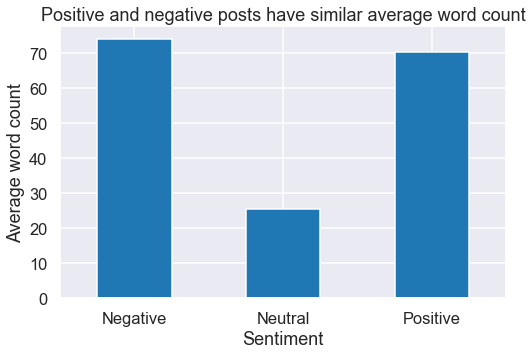

In [41]:
plt.figure(figsize=(8,5))
subreddits.groupby(['sentiment']).mean()['selftext_words'].plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Average word count')
plt.title('Positive and negative posts have similar average word count')
plt.xticks([0, 1, 2],labels=['Negative', 'Neutral', 'Positive'], rotation=0);

On average, neutral posts have less words than both negative and positive posts. But both positive and negative posts tend to have a similar word count distribution. 

#### Sentiment distribution for each subreddit 

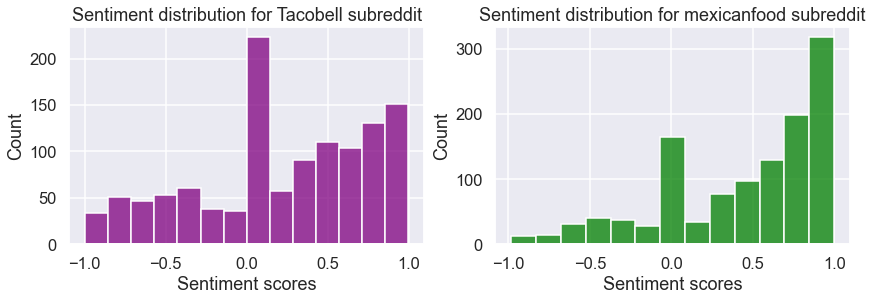

In [42]:
fig, ax = plt.subplots(1, 2,figsize=(14, 4))

sns.histplot(ax=ax[0], data=tacobell, x='sentiment_score', color='purple')
sns.histplot(ax=ax[1], data=mex_food, x='sentiment_score', color='green')

ax[0].title.set_text('Sentiment distribution for Tacobell subreddit')
ax[1].title.set_text('Sentiment distribution for mexicanfood subreddit')
ax[0].set_xlabel('Sentiment scores')
ax[1].set_xlabel('Sentiment scores');
plt.savefig('sentiment score dist', bbox_inches='tight')

The mexicanfood subreddit has a more favorable distribution of sentiment scores

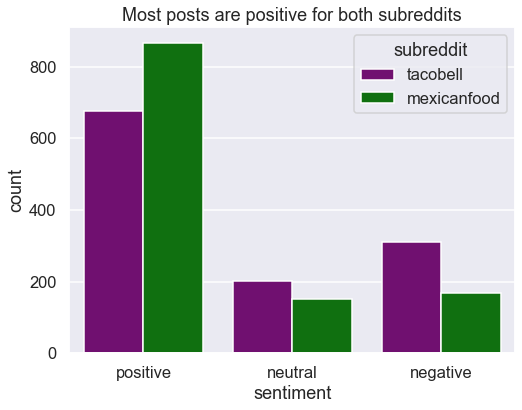

In [67]:
hue_colors={'tacobell': 'purple',
            'mexicanfood': 'green'}

order =['positive', 'neutral', 'negative']

plt.figure(figsize=(8,6))
sns.countplot(data=subreddits,
              x='sentiment', 
              hue='subreddit',
              palette=hue_colors,
              order=order)
plt.title('Most posts are positive for both subreddits');
plt.savefig('sentiment breakdown compare', bbox_inches='tight')

<Figure size 648x432 with 0 Axes>

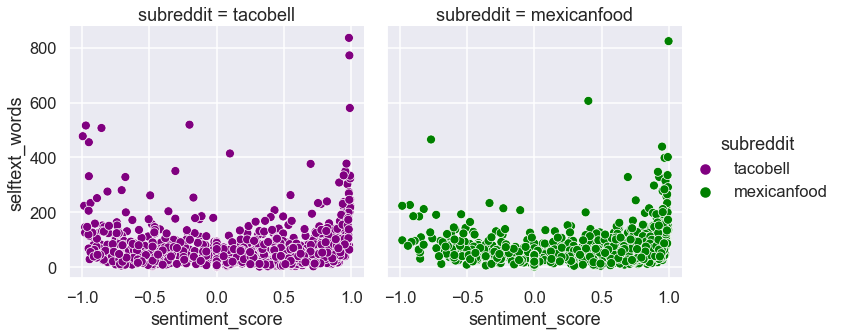

In [44]:
hue_colors={'tacobell': 'purple',
            'mexicanfood': 'green'}

plt.figure(figsize=(9, 6))
sns.relplot(data=subreddits, 
                y='selftext_words', 
                x='sentiment_score', 
                hue='subreddit', 
                col='subreddit', 
                palette=hue_colors);

While both subreddits have similar distributions of sentiment scores, less extremely negative posts (close to -1). The r/tacobell subreddit has much many strongly negative posts.

**Thoughts after analyzing sentiment distributions:**

For the purpose of my problem statement, I did not gain much insight by looking at sentiment distributions of both subreddits. However, I thought it was important to investigate whether any of the groups skewed either very negative or very positive so that we can take that into account when we analyze word count and words highlighted by our model. 
    

### Vectorizing for EDA

In [45]:
cv1 = CountVectorizer(stop_words='english')
cv2 = CountVectorizer(stop_words='english')

In [46]:
tacobell_text = tacobell['selftext']

mex_food_text = mex_food['selftext']

In [47]:
tacobell_cv = cv1.fit_transform(tacobell_text)

mex_food_cv = cv2.fit_transform(mex_food_text)

tacobell_cv = pd.DataFrame(tacobell_cv.A, columns = cv1.get_feature_names_out())

mex_food_cv = pd.DataFrame(mex_food_cv.A, columns = cv2.get_feature_names_out())

In [48]:
tacobell_cv.drop(columns=['don', 've'], inplace=True)

In [49]:
mex_food_cv.drop(columns=['don', 've'], inplace=True)

#### Plotting the most common words from each subreddit

In [50]:
#pip install wordcloud

In [63]:
sns.set_style('darkgrid')
sns.set_context('talk')

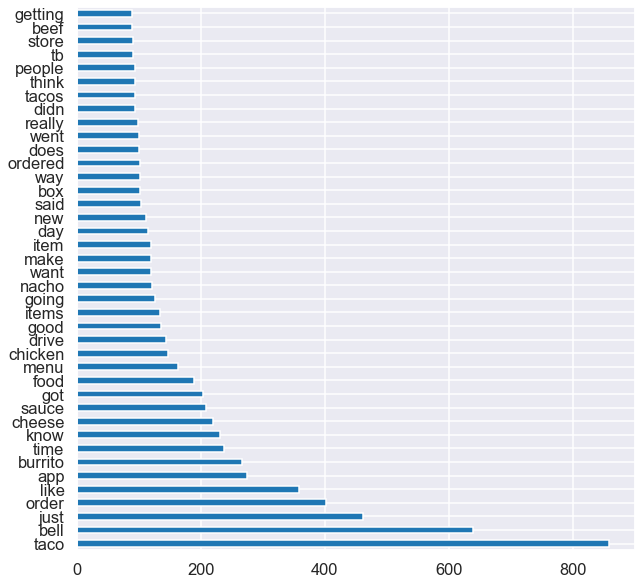

In [69]:
tb_top_40 = tacobell_cv.sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(10,10))
tb_top_40.plot(kind='barh');

Burrito is a VERY popular food item at Taco Bell, I noticed many customers appreciating the value burritos provide. Folks also mention cheese, sauce, nachos, tacos, chicken and beef very often. 

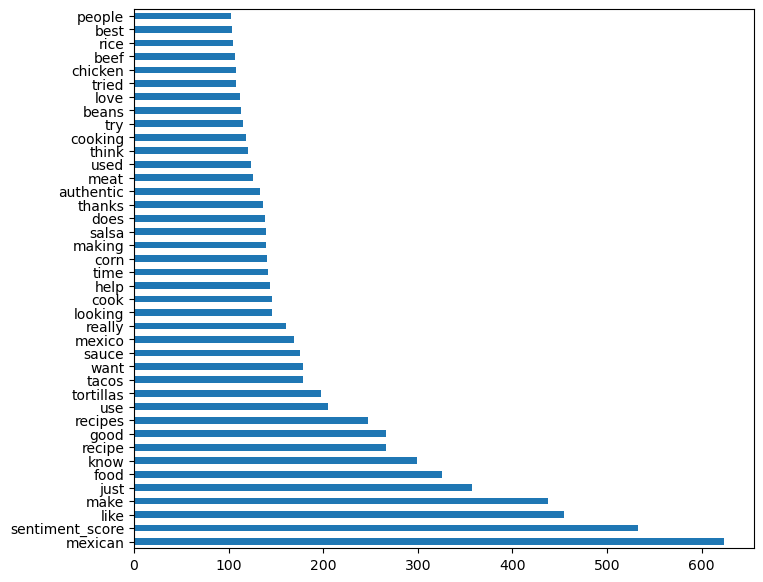

In [299]:
mf_top_40 = mex_food_cv.sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(8,7))
mf_top_40.plot(kind='barh');

In the r/mexicanfood subreddit, top popular food items are tortillas, salsa, corn (bet this is in conjuction with tortilla), meat, beans, rice.

In [54]:
from wordcloud import WordCloud, STOPWORDS

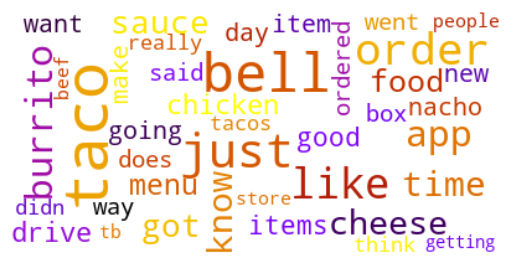

In [151]:
tacobell_cloud = WordCloud(background_color='white',
                           colormap='gnuplot',
                           random_state=728,
                           max_font_size=50).generate_from_frequencies(tb_top_40)
plt.imshow(tacobell_cloud, interpolation='bilinear')
plt.axis("off");
plt.savefig('tacobell wordcloud')

The top 40 words in the Taco Bell word cloud reflects that in most post people are discussing menu items, the ordering app, sauces, and orders. 

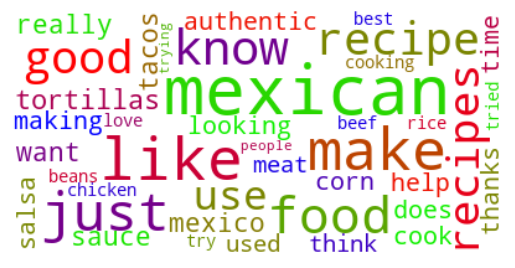

In [152]:
mex_food_cloud = WordCloud(background_color='white',
                           colormap='brg',
                           random_state=111,
                           max_font_size=55).generate_from_frequencies(mf_top_40)
plt.imshow(mex_food_cloud, interpolation='bilinear')
plt.axis("off");
plt.savefig('mexican food wordcloud')

The word cloud for the mexican reflects that many of the posts relate to questions and advice around cooking authentic mexican food, for instance we see the words: recipe, help, making, trying, cook, looking, authentic, try, use, and know. 

In [294]:
common_top_words = [word for word in tb_top_40.index if word in mf_top_40.index]
print(common_top_words)

['just', 'like', 'time', 'know', 'sauce', 'food', 'chicken', 'good', 'want', 'make', 'does', 'really', 'tacos', 'think', 'people', 'beef']


Both subreddits share 16 of their top 40 words. They share the following food-related words:
- sauce
- chicken
- tacos
- beef

In [295]:
diff_top_words = [word for word in mf_top_40.index if word not in tb_top_40.index]
print(diff_top_words)

['mexican', 'recipe', 'recipes', 'use', 'tortillas', 'mexico', 'looking', 'cook', 'help', 'corn', 'salsa', 'making', 'thanks', 'authentic', 'meat', 'used', 'cooking', 'try', 'beans', 'love', 'tried', 'rice', 'best', 'trying']


These are the words from r/mexicanfood that are not in top words in r/tacobell. Of note:
- tortillas
- corn
- salsa
- meat
- beans
- rice

#### Looking at word frequency of the most positive posts in both groups

In [83]:
tacobell_cv['sentiment_score'] = tacobell['sentiment_score']
tacobell_cv_pos = tacobell_cv[tacobell_cv['sentiment_score']>.90]

In [84]:
mex_food.reset_index(inplace=True)
mex_food_cv['sentiment_score'] = mex_food['sentiment_score']
mex_food_cv_pos = mex_food_cv[mex_food_cv['sentiment_score']>.90]

In [293]:
tacobell_cv_pos.sum().sort_values(ascending=False).head(20)

taco               203.000
bell               150.000
sentiment_score    102.627
like                94.000
just                86.000
order               62.000
burrito             58.000
time                57.000
know                54.000
good                48.000
food                46.000
cheese              41.000
items               39.000
got                 35.000
chicken             35.000
love                33.000
say                 32.000
day                 32.000
way                 31.000
location            30.000
dtype: float64

In [86]:
mex_food_cv_pos.sum().sort_values(ascending=False).head(20)

sentiment_score    213.3494
mexican            210.0000
like               198.0000
make               123.0000
food               122.0000
good               113.0000
just                99.0000
know                88.0000
recipes             79.0000
recipe              76.0000
love                65.0000
help                64.0000
use                 62.0000
sauce               61.0000
want                60.0000
mexico              59.0000
tortillas           56.0000
thanks              54.0000
authentic           53.0000
meat                51.0000
dtype: float64

Focusing on the most positive posts (sentiment_score > .9) we see that both subreddits use similar words such as 'like', 'love', but they focus on different food items. In the Taco Bell subreddit users enjoy burritos, cheese, and chicken the most (if we take these frequencies to be a proxy). 

In the mexicanfood subreddit, the most positive posts include food items such as sauce, tortillas, meat (more general than chicken). it. 

#### CountVectorize with bigrams

In [237]:
cv1 = CountVectorizer(stop_words='english', ngram_range=(2,2))
cv2 = CountVectorizer(stop_words='english', ngram_range=(2,2))

In [238]:
tacobell_text2 = tacobell['selftext']

mex_food_text2 = mex_food['selftext']

In [251]:
tacobell_cv2 = cv1.fit_transform(tacobell_text2)

mex_food_cv2 = cv2.fit_transform(mex_food_text2)

tacobell_cv2 = pd.DataFrame(tacobell_cv2.A, columns = cv1.get_feature_names_out())

mex_food_cv2 = pd.DataFrame(mex_food_cv2.A, columns = cv2.get_feature_names_out())

In [252]:
tacobell_cv2.drop(columns=['ve tried', 'don want'], inplace=True)
mex_food_cv2.drop(columns=['ve got', 've trying', 've seen', 've tried', 've got'], inplace=True)

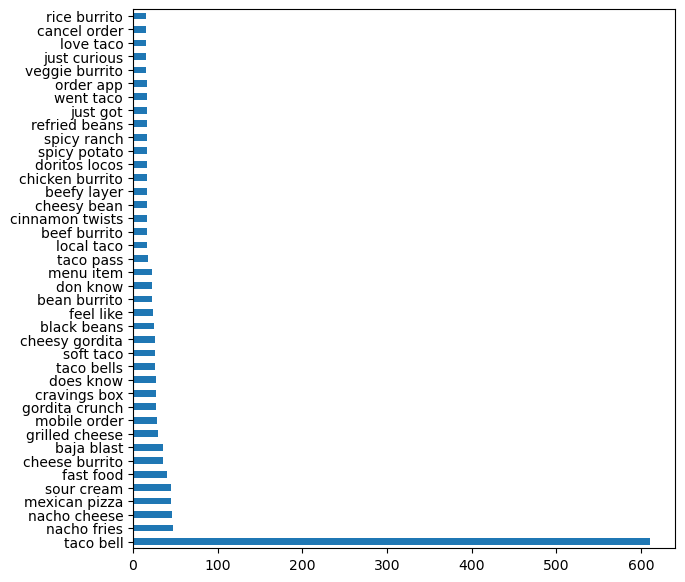

In [291]:
tb_top_40_2 = tacobell_cv2.sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(7,7))
tb_top_40_2.plot(kind='barh');

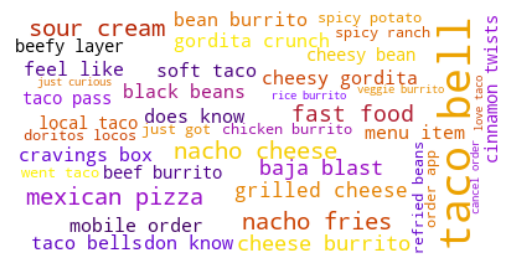

In [268]:
tacobell_cloud2 = WordCloud(background_color='white',
                           colormap='gnuplot',
                           random_state=728,
                           min_font_size=9,
                           max_font_size=35).generate_from_frequencies(tb_top_40_2)
plt.imshow(tacobell_cloud2, interpolation='bilinear')
plt.axis("off");
plt.savefig('tacobell wordcloud2')

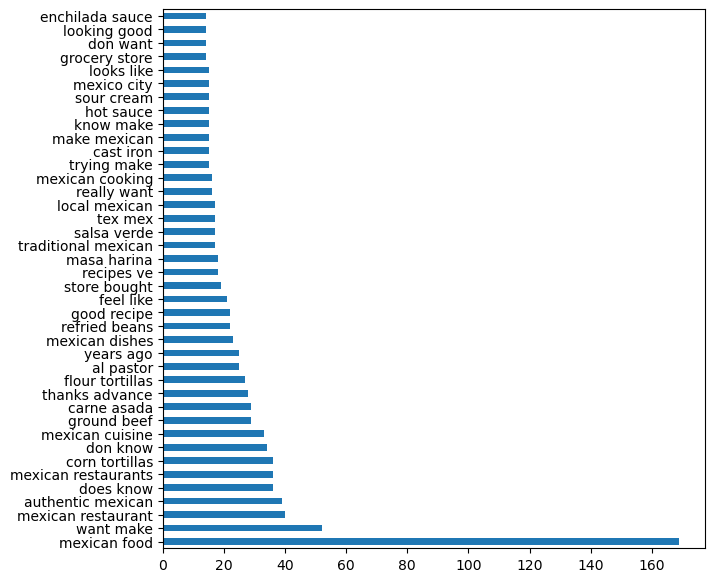

In [290]:
mf_top_40_2 = mex_food_cv2.sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(7,7))
mf_top_40_2.plot(kind='barh');

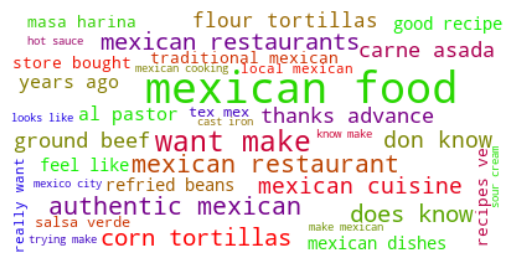

In [269]:
mex_food_cloud2 = WordCloud(background_color='white',
                           colormap='brg',
                           random_state=111,
                           min_font_size=9,
                           max_font_size=35).generate_from_frequencies(mf_top_40_2)
plt.imshow(mex_food_cloud2, interpolation='bilinear')
plt.axis("off");
plt.savefig('mexican food wordcloud2')

Bigrams was really helpful in highlighting mexican food items that are most popular from the mexicanfood that are not present in the Taco Bell menu:
- Corn tortillas (they do use hard shell corn tortillas but these are seldom used in mexican food)
- carne asada (grilled steak)
- salsa verde
- al pastor (grilled pork)

### Modeling

#### Split train/test

In [87]:
X = subreddits['selftext']
y = subreddits['subreddit']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)

#### Vectorize/Tokenize

In [89]:
#stop_words='english', ngram_range=(1, 2)

In [90]:
cvec = CountVectorizer()

X_train_cv = cvec.fit_transform(X_train)

X_test_cv = cvec.transform(X_test)

X_train_cv = pd.DataFrame(X_train_cv.A, columns = cvec.get_feature_names_out())

X_test_cv = pd.DataFrame(X_test_cv.A, columns = cvec.get_feature_names_out())

#### First Model using Logistic Regression

This will be our first model, using only default parameters on countvectorizer and on logisticregression.  We will use this model as our baseline.

In [91]:
lr = LogisticRegression(max_iter=10_000)

lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=10000)

In [92]:
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.9966273187183811, 0.9376053962900506)

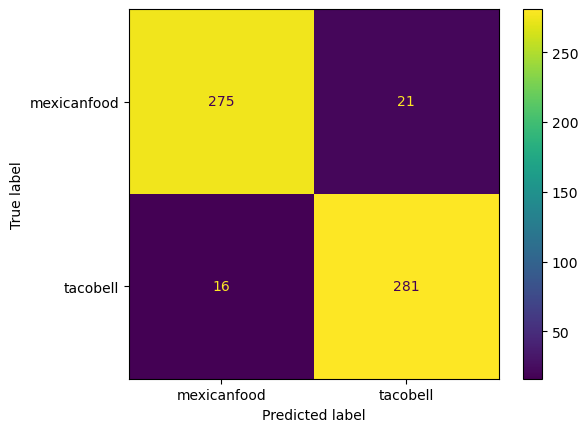

In [146]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

ConfusionMatrixDisplay.from_estimator(lr, X_test_cv, y_test)
plt.savefig('baseline confusion matrix')

In [94]:
recall_score(y_test, lr.predict(X_test_cv), pos_label='mexicanfood')

0.9290540540540541

In [95]:
precision_score(y_test, lr.predict(X_test_cv), pos_label='mexicanfood')

0.9450171821305842

This is a very simple logistic regression with tokenize data using CountVectorizer with no hyperparameters specified. This model only uses the text data, but is able to differentiate between the mexicanfood subreddit and the tacobell subreddit very well. 

#### Grid Search Across CountVectorize with AdaBoost estimator

In [96]:
params = {
        'cv__stop_words' : ['english', None],
        'cv__lowercase': [True, False],
        'cv__ngram_range': [(1, 1), (1, 2)],
        'cv__min_df': [2, 3],
        'abc__n_estimators': [100, 150, 200]
}

In [97]:
pipe = Pipeline([
        ('cv', CountVectorizer()),
        ('abc', AdaBoostClassifier())
])

In [98]:
gs = GridSearchCV(pipe, param_grid=params, n_jobs=-1)

In [99]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('abc', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'abc__n_estimators': [100, 150, 200],
                         'cv__lowercase': [True, False], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': ['english', None]})

In [101]:
gs.best_score_

0.9258094635227092

In [102]:
gs.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(min_df=2)),
                ('abc', AdaBoostClassifier(n_estimators=200))])

In [103]:
gs.best_params_

{'abc__n_estimators': 200,
 'cv__lowercase': True,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': None}

In [104]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9971894322653176, 0.9089376053962901)

Accuracy score for X_test is lower than the baseline logistic regression. Here, since the data is not imbalanced, the accuracy score is helpful. We can undestand from this score that the model is not generalizing as well as the baseline model. 

In [270]:
recall_score(y_test, gs.predict(X_test), pos_label='mexicanfood')

0.902027027027027

In [272]:
f1_score(y_test, gs.predict(X_test), pos_label='mexicanfood')

0.9081632653061223

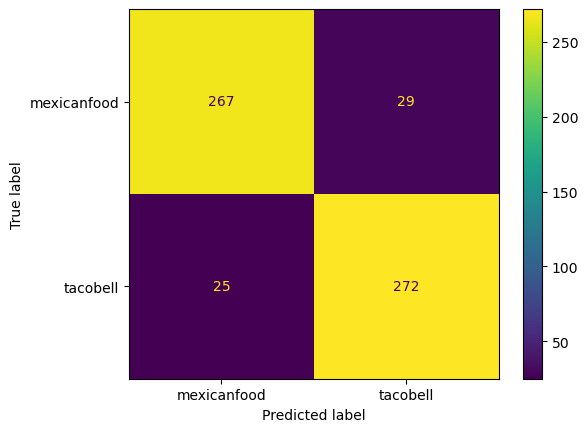

In [147]:
ConfusionMatrixDisplay.from_predictions(y_test, gs.predict(X_test));
plt.savefig('AdaBoost confusion matrix')

The confusion matrix confirms that this model generalizes less well. It has misclassified a larger number of post that are actually from r/mexicanfood, and also misclassified a larger number of post that are actually from the tacobel subreddit. 

In [106]:
df_feats = pd.DataFrame(gs.best_estimator_['abc'].feature_importances_, index=gs.best_estimator_['cv'].get_feature_names_out(), columns=['ft_imps'])

In [288]:
df_feats[df_feats['ft_imps'] != 0].sort_values(by='ft_imps', ascending=False).head(20).T

,mexican,looking,recipe,bell,tortillas,they,made,do,the,that,some,going,help,in,hi,could,salsa,recipes,make,meat
ft_imps,0.03,0.025,0.02,0.015,0.015,0.015,0.015,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


**Analysis on Gridsearch with AdaBoost:**

AdaBoost with Gridserach did not provide stronger results than the baseline logistic regression. While AdaBoost may not be the best model for this situtation, looking at the feature importances has been informative. Food-related words that the model has highlighted as important in differentiating between both subreddits include:

- Tortillas
- Salsa
- Meat


#### Gridsearch across CV with KNN 

In [108]:
params2 = {
        'cv__stop_words' : ['english', None],
        'cv__lowercase': [True, False],
        'cv__ngram_range': [(1, 1), (1, 2)],
        'cv__min_df': [2, 3],
        'cv__max_df': [.9, .95],
        'knn__n_neighbors': [3, 5, 7],
        'knn__weights': ['uniform', 'distance']
}

In [109]:
pipe2 = Pipeline([
        ('cv', CountVectorizer()),
        ('knn', KNeighborsClassifier())
])

In [110]:
gs2 = GridSearchCV(pipe2, param_grid=params2, n_jobs=-1)

In [111]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__max_df': [0.9, 0.95], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': ['english', None],
                         'knn__n_neighbors': [3, 5, 7],
                         'knn__weights': ['uniform', 'distance']})

In [112]:
gs2.best_score_

0.677336603893021

In [113]:
gs2.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(lowercase=False, max_df=0.9, min_df=3,
                                 stop_words='english')),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

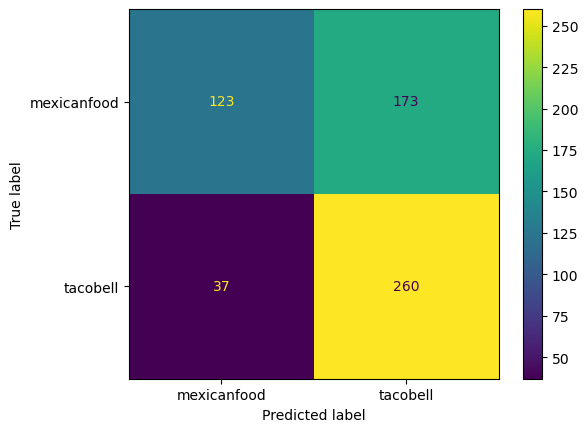

In [148]:
ConfusionMatrixDisplay.from_predictions(y_test, gs2.predict(X_test))

**Analysis on Gridsearch with KNN:**

Gridserach with KNN performed quite poorly compared to the AdaBoost and Logistic Regression model. The number of post that are actually from the mexicanfood subreddit but are classified as tacobell increased by more than 8 times. 

#### CountVectorizer and Gaussian Naive Bayes 

In [121]:
cv2 = CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=.90)

X_train_cv2 = cv2.fit_transform(X_train)

X_test_cv2 = cv2.transform(X_test)

X_train_cv2 = pd.DataFrame(X_train_cv2.A, columns = cv2.get_feature_names_out())

X_test_cv2 = pd.DataFrame(X_test_cv2.A, columns = cv2.get_feature_names_out())

In [122]:
gnb = GaussianNB()

gnb.fit(X_train_cv2, y_train)

GaussianNB()

In [123]:
gnb.score(X_train_cv2, y_train), gnb.score(X_test_cv2, y_test)

(0.9910061832490163, 0.9426644182124789)

In [124]:
f1_score(y_test, gnb.predict(X_test_cv2), pos_label='mexicanfood')

0.9421768707482994

In [125]:
f1_score(y_test, gnb.predict(X_test_cv2), pos_label='tacobell')

0.9431438127090301

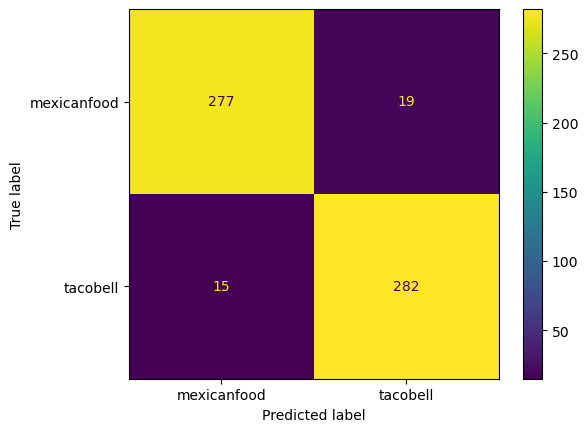

In [149]:
ConfusionMatrixDisplay.from_predictions(y_test, gnb.predict(X_test_cv2))

**Analysis with Gaussian Naive Bayes**

The model has performed best pairing CountVectorizer with Gaussian Naive Bayes. With GNB I was not able to gridsearch because the model does like using a sparse matrix, so I tried out many different hyperparams for CV by hand before finding this combination that worked really well. 

Lastly, I do want to try logistic regression again, this time searching across different hyper-parameters for the tokenizer and the model. 

### GridSearch across CV and Logistic Regression

Because Logistic regression performed well with default settings for CountVectorizer and LogisticRegression, it is worth checking whether performance would improve if we search across different hyperparameters

In [153]:
params3 = {
        'cv__stop_words' : ['english', None],
        'cv__lowercase': [True, False],
        'cv__ngram_range': [(1, 1), (1, 2)],
        'cv__min_df': [2, 3],
        'cv__max_df': [.9, .95],
        'lr__C': [0.1, 0.5, 1, 1.5],

}

In [154]:
pipe3 = Pipeline([
        ('cv', CountVectorizer()),
        ('lr', LogisticRegression())
])

In [155]:
gs3 = GridSearchCV(pipe3, param_grid=params3, n_jobs=-1, scoring='balanced_accuracy')

In [156]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cv__lowercase': [True, False],
                         'cv__max_df': [0.9, 0.95], 'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': ['english', None],
                         'lr__C': [0.1, 0.5, 1, 1.5]},
             scoring='balanced_accuracy')

In [157]:
gs3.score(X_train, y_train), gs3.score(X_test, y_test)

(0.9865029511760468, 0.9493755118755118)

In [158]:
gs3.best_params_

{'cv__lowercase': True,
 'cv__max_df': 0.9,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english',
 'lr__C': 0.5}

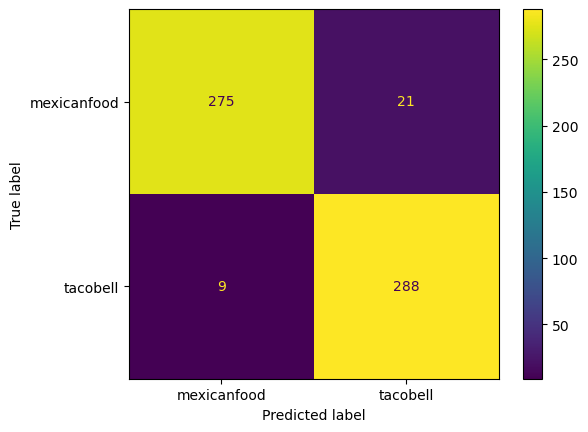

In [210]:
ConfusionMatrixDisplay.from_predictions(y_test, gs3.predict(X_test))
plt.savefig('best model confusion matrix', bbox_inches='tight')

In [134]:
f1_score(y_test, gs3.predict(X_test), pos_label='mexicanfood')

0.9482758620689656

In [135]:
f1_score(y_test, gs3.predict(X_test), pos_label='tacobell')

0.9504950495049505

This last model has a higher accuracy score than the baseline logistic regression model by adding max_df and min_df setting inside the CountVectorizer, and by setting C to .5, thereby increasing regularization. It also has higher f1_scores regardless of the positive label used. (For the purposes of this project I am agnostic regarding the positive label.)

While this model increased the number of mexicanfood posts that are incorrectly marked as tacobell posts, it does a much better job at correctly labeling tacobell posts, and reduced the number of posts from the tacobell post that was marked as coming from the mexicanfood subreddit. Becuase of its better accuracy score and its higher f1_scores, this is the better model to use, though its performance is quite comprable to the baseline model.  

The high accuracy of this model, provides confidence that we can look at the model's coefficients to draw some insight.

### What insights do we get from our best model?

In [276]:
coefs_df = pd.DataFrame(gs3.best_estimator_['lr'].coef_[0], index=gs3.best_estimator_['cv'].get_feature_names_out(), columns=['coefs'])

In [277]:
coefs_df.sort_values(by='coefs', ascending=False, inplace=True)

In [282]:
s1 = coefs_df.head(15)

s2 = coefs_df.tail(15)

In [280]:
coefs_df2 = pd.concat([s1, s2])

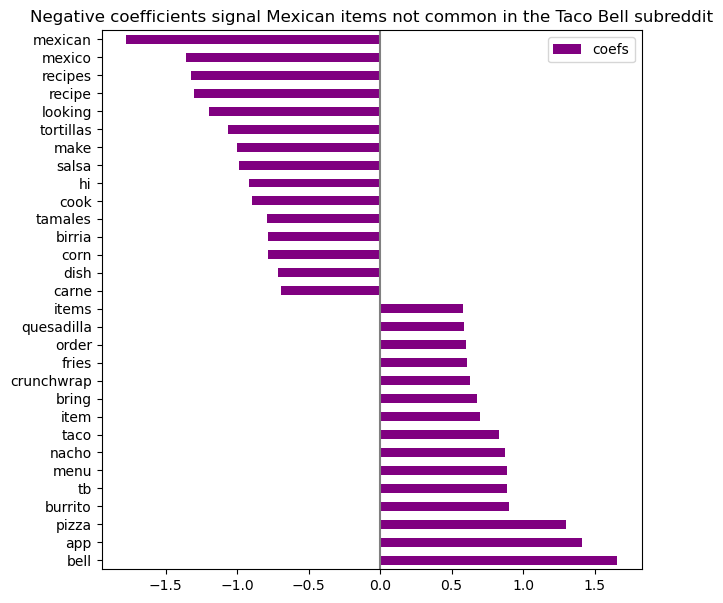

In [281]:
coefs_df2.plot(kind="barh", figsize=(9, 7), color='purple')
plt.title("Negative coefficients signal Mexican items not common in the Taco Bell subreddit")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.savefig('logreg coefficients')

#### Insight from the coefficients:

Focusing only at the most significant coefficients, those that have the largest impact on whether a post is more likely or less likely to be of the positive category, we can see again that certain food items appear a lot in the r/mexicanfood subreddit and therefore were key for the model in differentiating between both groups. 

As our EDA and the AdaBoost model highlighted above, r/mexicanfood is very focused on tortillas, carne, and salsa. The logistic regression above also highlights tamales and birria (a taco type) that can be interesting for Taco Bell to explore. 

### Analysis

In the above analysis, I sought to identify popular food items from Mexican cuisine that may be missing from the Taco Bell menu. While Taco Bell is not known for its authenticity, it has done a great job of taking key ideas from mexican food to recreate an exciting menu that attracts a loyal consumer base. To identify popular items from Mexican food, I explored about 1200 posts from r/mexicanfood subreddit. I also explored about 1200 post from the r/tacobell subreddit to understand favorite food items from the franchise, and overall customer preferences and sentiments that can inform my final recommendations.

**Sentiment Analysis**

In the EDA process above we identified that posts from both subreddits had a high proportion of unique authors, and shared a similar distribution of post length. Insights began to emerged when we used VADER's sentiments analysis to assign each post a sentiment score. We then used the sentiment scores to segregate very positive posts and very negatives posts. Exploring posts that scored as very positive I noticed that in the users of r/mexicanfood had the following favorite foods:
- *salsas (sauces) and meat (carne)*

Exploring positive posts from the r/tacobell subreddit highlighted priorities for this customer base:
- *affordability and convenience*

**Most Frequent Words Analysis**

The top 40 words in r/mexicanfood included the following food-related words:
- *sauce, chicken, tacos, beef, (corn) tortillas, salsa, meats, beans, and rice*

And these are all ingredients (corn tortillas to a lesser extend) that are part of Taco Bell's menu, highlighting that Taco Bell does a good job of incorporating popular Mexican ingredients into their Menu. 

Other frequent words in the r/tacobell subreddit stresses that Taco Bell customers are not only interested in their food experience, but care just as much about the ease of the transaction. 
The word *app* and *drive* are also among the most frequent words, meaning customers often write about their purchasing experience. 

**Most Frequent Words Pairs Analysis**

I also used CountVectorizer to explore bigrams (pairs of words) that were most popular in each subreddit, which identified specific items from Mexican food are very popular, including:
- Corn tortilla, carne asada, salsa verde, al pastor

These items are not currently present in the Taco Bell menu, so they do present an opportunity for the product development team to explore. 

**Modeling**

Lastly, I explored classification models to confirm the insights we gained from the EDA, and explore other patterns in the data. I used an AdaBoost model that performed very well with few cases of misclassification and accuracy score of 0.90. I, therefore, feel confident that we can use the feature importances identified by this model to better understand the data. Food-related words identified by the model as meaningful in distinguishing between both subreddits include tortillas, salsa, and meat. Words that our EDA had already identified as being prominent in the r/mexicanfood subreddit, but less prominent in r/tacobell.

I also used a logistic regression model with an accuracy score of 0.95. Examining the model's coefficients we saw that the model identified many of the same words as our EDA and AdaBoost \. However, this model identified tamales and birria as significant words in classifying posts from r/mexicanfood. And in fact, these are two items that are not currently part of the Taco Bell menu. 

### Recommendations

Our analysis of r/mexicanfood and r/tacobell subreddits helped identify important ingredients and foods that are popular and prominent in Mexican cuisine. Taco Bell has done a really great job of incorporating most of the popular components. However, I want to highlight opportunities to enhance the Taco Bell menu with popular Mexican cuisine items. 

**Identified Opportunities**

- The data shows that corn tortillas are very popular in Mexican cuisine, perhaps Taco Bell should explore whether they should offer corn tortilla soft tacos 
- Salsas (sauces) are another prominent component of Mexican cuisine, and while Taco Bells does a great job of developing many different sauces, our analysis suggests that Taco Bell should explore the development of more authentic sauces - and consider branding them as salsas.
-  Meats are another important food component in Mexican cuisine, of note is the emphasis in different types of meat preparations. In particular carne asada and al pastor where identified in our EDA as favorites. Again, our data suggest that Taco Bell should explore its meat offerings. 
- Lastly, the logistic model identified two Mexican food items that were not revealed during our EDA. Tamales and Birria (tacos) are very popular items not yet incorporated by Taco Bell. While tamales does not fit the profile of the typical Taco Bell item, birria tacos - which are currently surging in popularity - may be a good fit. Birria tacos are essentially very saucy tacos with cheese and meat filling (ingredients already developed). 

**Additional Considerations**

The opportunities above are suggestions for the product development team who seek new ideas to expand it's menu. However, these are merely suggestions that should be further explored in conjunction with the business and marketing team to determine whether adding corn tortillas, developing salsa, or adding birria tacos is appropriate.

Our analysis also identified that customers priorities includes costs and convenience, which are additional factors to consider when expanding the menu. 
